### Part 1. Exploratory Data Analysis.

#### 1.1 Load the data.

In [64]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import numpy as np
import pandas as pd
from datetime import datetime
%matplotlib inline
import seaborn as sns
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
#df = pd.read_csv('groupon.txt', sep=None, engine='python')

In [3]:
#df.to_parquet('groupon.parquet')

In [4]:
df = pd.read_parquet('groupon.parquet')

In [5]:
df.head()

,refund_bucket,refund_sub_bucket,order_date,transaction_date,week_end_date,dmm_subcat_1,category_1,deal_supply_channel,buyer_name_1,auth_bookings,capture_bookings,refunds,cancel_refunds,refunded_units,auth_refunds,capture_units
0,Other,Other,8/4/2016,8/4/2016,8/7/2016,Inverse Normal,Probability distribution II,Goods Stores,Asher,?,?,91.87,?,3,?,?
1,Returns,Change of mind,8/31/2018,9/21/2018,9/23/2018,Binomial Distribution.,Probability distribution I,Goods,Jesus,?,?,20.98,?,1,?,?
2,Fraud,Fraud,4/19/2017,4/19/2017,4/23/2017,Power series,Calculus II,Goods,Tristan,?,?,?,79.94,?,?,?
3,Two-Hour Refunds,Two-Hour Refunds,2/5/2016,2/5/2016,2/7/2016,Prime Factorization Algorithms,?,Goods,Jeremiah,?,?,49.267469958,?,1,?,?
4,Shortage Cancellations,Vendor Shortage,7/21/2018,8/15/2018,8/19/2018,Transformations,Geometry,Goods,Jacob,?,?,29.97,?,2,?,?


Our dataframe consists of 16 columns and approximately 6.8 millions rows. The dataframe is huge as it occupies almost 1 GB of memory. Python loaded all columns as objects - so we need to transform data into right data type. The original dictionary with data types description is provided below.

|Column_name	                |Type		|Description
| --- | --- | --- |
|refund_bucket                 	|Varchar	|Reason for refunding customer
|refund_sub_bucket             	|Varchar	|Sub reason for refunding customer
|transaction_date              	|Date		|date of refund
|week_end_date                 	|Date		|weekend date of refund
|dmm_subcat                    	|Varchar	|sub category of product
|category                      	|Varchar	|category of product
|deal_supply_channel           	|Varchar	|channel of sale
|buyer_name                    	|Varchar	|name of buyer who sourced the product
|auth_bookings                 	|Float		|bookings authorized on card
|capture_bookings              	|Float		|bookings captured
|refunds                       	|Float		|amount of refund
|cancel_refunds                	|Float		|refunds if the transaction was a cancellation
|refunded_units                	|Integer	|quantity of product for which refunds were issued
|auth_refunds                  	|Integer	|	
|capture_units                 	|Integer	|	

To allow a faster processing and easy data manipulation let's subset our dataframe to separate one year of transactions and refunds based on a transaction date. I will take May 2018 - April 2019 data. 

To do so I need to convert all date's columns to Python date-time format and will use a boolean mask to create a subset.

In [6]:
df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'], infer_datetime_format=True)
df['week_end_date'] = pd.to_datetime(df['week_end_date'], infer_datetime_format=True)

Since I have already converted date's columns to date format, I can set a desired date to filter a dataframe. Then I will assign a mask to dateaframe.

In [7]:
start_date = '2018-04-01'
mask = df['transaction_date'] >= start_date
subset = df.loc[mask]
subset.shape

(2140082, 16)

#### 1.2. Data Cleaning and Transformation

In [8]:
subset = subset.copy()

In [9]:
subset['refunded_units'] = subset['refunded_units'].str.replace('?', '0').astype(int)

Now when we convereted refunded units into integer data type, let's work with auth_refunds, and capture_units in the same way.

In [10]:
subset['auth_refunds'] = subset['auth_refunds'].str.replace('?', '0').astype(int)
subset['capture_units'] = subset['capture_units'].str.replace('?', '0').astype(int)

Now let's convert auth_bookings, capture_bookings, refunds, and cancel_refunds columns into the float data type.

In [11]:
subset['auth_bookings'] = subset['auth_bookings'].str.replace('?', '0').astype(float)
subset['capture_bookings'] = subset['capture_bookings'].str.replace('?', '0').astype(float)
subset['refunds'] = subset['refunds'].str.replace('?', '0').astype(float)
subset['cancel_refunds'] = subset['cancel_refunds'].str.replace('?', '0').astype(float)

I am done with data type transformations. Now let's replace question marks with unknown values in our categorical columns and see what categories and how many of them do I have.

I have 139 unique subcategories in dummy subcategory column.

In [12]:
subset['dmm_subcat_1'] = subset['dmm_subcat_1'].str.replace('?', 'unknown')
print(subset['dmm_subcat_1'].nunique())
# print(subset['dmm_subcat_1'].value_counts().head(10))

139


I have only 14 categories compare to 139 subcategories. In reality categories are actual product categories that Groupon sells online but for our project purposes they were replaced with college math classes names.

In [13]:
subset['category_1'] = subset['category_1'].str.replace('?', 'unknown')
print(subset['category_1'].nunique())

14


There are only two unique supply channels: goods or goods stores.

In [14]:
subset['deal_supply_channel'].value_counts()

Goods           1893570
Goods Stores     246512
Name: deal_supply_channel, dtype: int64

Buyer names are not the actual buyers but rather the employees who sell the particular products. There are 273 unique employees in our subset.

In [15]:
subset['buyer_name_1'] = subset['buyer_name_1'].str.replace('?', 'Unknown')
print(subset['buyer_name_1'].nunique())

273


Our refund bucket column consists of seven buckets, which are general reasons for return.
In addition, we have 18 subbuckets columns that also specify the refund reasons.

In [16]:
subset['refund_bucket'] = subset['refund_bucket'].str.replace('?', 'Unknown')
subset['refund_sub_bucket'] = subset['refund_sub_bucket'].str.replace('?', 'Unknown')
print(subset['refund_sub_bucket'].nunique())

18


#### 1.3 Data Analysis and Visualization.

In [17]:
# subset.describe().T

As we can see the company might not be able to decrease refunds in Other, Returns, or Two-Hour Refunds. However, the company can definetly decrease refunds in such categories as Logistic Cancellations, Shortage Cancellations, and Fraud.

In [18]:
for bucket, frame in subset.groupby('refund_bucket'):
    avg = np.round(np.average(frame['refunds']),2)
    print('The average amount of refund in ' + bucket + ' was ' + str(avg))

The average amount of refund in Fraud was 19.14
The average amount of refund in Logistics Cancellations was 42.98
The average amount of refund in Other was 36.17
The average amount of refund in Returns was 66.16
The average amount of refund in Shortage Cancellations was 61.36
The average amount of refund in Two-Hour Refunds was 44.57
The average amount of refund in Unknown was 0.0


Let's see the average amounts of refunds by sub category. The same rule applies to sub category column - there are definetly areas for improvement, especially in such sub buckets as Groupon error, Other Shortage, Shipping Issues, 
Warehouse Shortage, etc. `m

Grouping data by refund bucket gives us a very useful insight about the dataset: all valid transactions with no refunds fall into a category 'Unknown' under a refund bucket column, which makes the 'unknown' refund bucket the biggest refund category in the dataset. This fact makes data analysis harder because I don't actually know what products under each particular refund category were bought the most.

In [19]:
subset.groupby(['refund_bucket','refund_sub_bucket']).agg(
min_refund=pd.NamedAgg(column='refunds', aggfunc=np.min),
min_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.min),
max_refund=pd.NamedAgg(column='refunds', aggfunc=np.max),
max_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.max),
avg_refund=pd.NamedAgg(column='refunds', aggfunc=np.mean),
avg_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.mean))

min_refund  min_transaction  \
refund_bucket           refund_sub_bucket                                       
Fraud                   Fraud                           0.00             0.00   
Logistics Cancellations Dead Tracking                   0.00             0.00   
                        Purchase Issues                 0.00             0.00   
                        Returned to Sender              0.00             0.00   
                        Shipping Issues                 0.00             0.00   
                        Tracking Shows Delivered       -1.63             0.00   
Other                   Other                        -637.50             0.00   
Returns                 Change of mind              -4598.00             0.00   
                        Other Returns                   0.00             0.00   
                        Product Quality               -10.41             0.00   
                        Wrong Size                      0.00             0.00   
                        Wrong/Damaged Product         -18.77             0.00   
Shortage Cancellations  Groupon Error                   0.00             0.00   
                        Other Shortage                  0.00             0.00   
                        Vendor Shortage                 0.00             0.00   
                        Warehouse Shortage              0.00             0.00   
Two-Hour Refunds        Two-Hour Refunds                0.00             0.00   
Unknown                 Unknown                         0.00             0.00   

                                                  max_refund  max_transaction  \
refund_bucket           refund_sub_bucket                                       
Fraud                   Fraud                        5699.97             0.00   
Logistics Cancellations Dead Tracking               16574.35             0.00   
                        Purchase Issues              2999.90             0.00   
                        Returned to Sender           2449.93             0.00   
                        Shipping Issues              3199.99             0.00   
                        Tracking Shows Delivered     9249.00             0.00   
Other                   Other                        2899.00             0.00   
Returns                 Change of mind              10369.37             0.00   
                        Other Returns                5576.43             0.00   
                        Product Quality             14169.14             0.00   
                        Wrong Size                   2679.84             0.00   
                        Wrong/Damaged Product        4549.85             0.00   
Shortage Cancellations  Groupon Error                9024.50             0.00   
                        Other Shortage               2289.00             0.00   
                        Vendor Shortage             17187.12             0.00   
                        Warehouse Shortage           2719.96             0.00   
Two-Hour Refunds        Two-Hour Refunds            10174.82             0.00   
Unknown                 Unknown                         0.00       1953473.05   

                                                  avg_refund  avg_transaction  
refund_bucket           refund_sub_bucket                                      
Fraud                   Fraud                          19.14             0.00  
Logistics Cancellations Dead Tracking                  49.38             0.00  
                        Purchase Issues                20.69             0.00  
                        Returned to Sender             45.07             0.00  
                        Shipping Issues                46.77             0.00  
                        Tracking Shows Delivered       47.60             0.00  
Other                   Other                          36.17             0.00  
Returns                 Change of mind                 76.72             0.00  
        

As explained by Groupon team, they do not use refund amount to analyze refunds. The better measure for this is a refund rate - refund amount compared to total transaction amount.

Let's add a refund rate column to our dataset to generate some insights.

In [20]:
by_category = subset.groupby(['category_1']).agg(
min_refund=pd.NamedAgg(column='refunds', aggfunc=np.min),
min_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.min),
max_refund=pd.NamedAgg(column='refunds', aggfunc=np.max),
max_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.max),
avg_refund=pd.NamedAgg(column='refunds', aggfunc=np.mean),
avg_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.mean)).sort_values(by = 'avg_transaction',ascending=False)
by_category['refund_rate'] = (by_category['avg_refund']/by_category['avg_transaction'])*100
by_category

,min_refund,min_transaction,max_refund,max_transaction,avg_refund,avg_transaction,refund_rate
category_1,,,,,,,
Calculus II,-637.50,0.00,16574.35,1953473.05,74.46,923.89,8.06
Graph Theory,-55.38,0.00,2879.90,195730.62,25.05,759.56,3.30
Probability distribution II,-4598.00,0.00,5371.80,270776.06,34.14,703.41,4.85
Linear Regression,-200.00,0.00,5276.60,165051.78,21.76,557.21,3.91
Clustering algorithms,0.00,0.00,1329.36,21153.00,45.93,457.18,10.05
Geometry,-200.00,0.00,17187.12,162782.00,16.33,451.11,3.62
Algebra,-348.25,0.00,9249.00,100926.43,23.66,439.31,5.38
Probability distribution I,-205.00,0.00,7211.08,170148.28,28.67,424.26,6.76
unknown,-170.00,0.00,9024.50,77712.60,19.44,385.77,5.04


In [21]:
by_subcategory = subset.groupby(['category_1','dmm_subcat_1']).agg(
min_refund=pd.NamedAgg(column='refunds', aggfunc=np.min),
min_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.min),
max_refund=pd.NamedAgg(column='refunds', aggfunc=np.max),
max_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.max),
avg_refund=pd.NamedAgg(column='refunds', aggfunc=np.mean),
avg_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.mean))
by_subcategory['refund_rate'] = (by_subcategory['avg_refund']/by_subcategory['avg_transaction'])*100
by_subcategory.sort_values(by=['avg_transaction','avg_refund','refund_rate'], ascending=False).head(10)

min_refund  \
category_1                  dmm_subcat_1                                  
Calculus II                 Maclaurin series                    -637.50   
Probability distribution II Generalized Error Distribution.     -344.50   
Geometry                    Proofs                                 0.00   
Probability distribution II Mixture Distribution                -100.00   
Graph Theory                Mengers theorem                       -8.00   
Probability distribution II Kumaraswamy Distribution             -85.59   
                            Lognormal Distribution.             -108.99   
Calculus II                 Surface of revolution                -42.72   
                            Taylor series                        -40.00   
Graph Theory                Hamiltonian Graphs                   -15.00   

                                                             min_transaction  \
category_1                  dmm_subcat_1                                       
Calculus II                 Maclaurin series                            0.00   
Probability distribution II Generalized Error Distribution.             0.00   
Geometry                    Proofs                                      0.00   
Probability distribution II Mixture Distribution                        0.00   
Graph Theory                Mengers theorem                             0.00   
Probability distribution II Kumaraswamy Distribution                    0.00   
                            Lognormal Distribution.                     0.00   
Calculus II                 Surface of revolution                       0.00   
                            Taylor series                               0.00   
Graph Theory                Hamiltonian Graphs                          0.00   

                                                             max_refund  \
category_1                  dmm_subcat_1                                  
Calculus II                 Maclaurin series                   16574.35   
Probability distribution II Generalized Error Distribution.     2249.97   
Geometry                    Proofs                              1129.75   
Probability distribution II Mixture Distribution                5170.82   
Graph Theory                Mengers theorem                     1806.77   
Probability distribution II Kumaraswamy Distribution            5371.80   
                            Lognormal Distribution.             2099.26   
Calculus II                 Surface of revolution              10499.30   
                            Taylor series                      12423.99   
Graph Theory                Hamiltonian Graphs                  2103.20   

                                                             max_transaction  \
category_1                  dmm_subcat_1                                       
Calculus II                 Maclaurin series                      1953473.05   
Probability distribution II Generalized Error Distribution.         78423.72   
Geometry                    Proofs                                  84401.78   
Probability distribution II Mixture Distribution                   238032.01   
Graph Theory                Mengers theorem                        192124.50   
Probability distribution II Kumaraswamy Distribution               270776.06   
                            Lognormal Distribution.                175344.76   
Calculus II                 Surface of revolution                  334352.40   
                            Taylor series                          381296.96   
Graph Theory                Hamiltonian Graphs                     160479.92   

                                                             avg_refund  \
category_1                  dmm_subcat_1                                  
Calculus II                 Maclaurin series                     204.78   
Probability distribution II Generalized Error Distribution.       61.83   
Geometry                    Proofs   

The highest refund rate belongs to buyer Zoey but she is very productive employee with the highest amount of average transaction.

In [22]:
by_buyer = subset.groupby(['buyer_name_1']).agg(
min_refund=pd.NamedAgg(column='refunds', aggfunc=np.min),
min_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.min),
max_refund=pd.NamedAgg(column='refunds', aggfunc=np.max),
max_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.max),
avg_refund=pd.NamedAgg(column='refunds', aggfunc=np.mean),
avg_transaction=pd.NamedAgg(column='capture_bookings', aggfunc=np.mean))
by_buyer['refund_rate'] = (by_buyer['avg_refund']/by_buyer['avg_transaction'])*100
by_buyer.sort_values(by=['avg_transaction','avg_refund','refund_rate'], ascending=False).head(10)

,min_refund,min_transaction,max_refund,max_transaction,avg_refund,avg_transaction,refund_rate
buyer_name_1,,,,,,,
Zoey,-637.50,0.00,16574.35,1953473.05,465.06,4195.67,11.08
Stella,-210.00,0.00,2649.90,270776.06,134.97,1759.89,7.67
Penelope,-50.00,0.00,12423.99,381296.96,81.80,1755.04,4.66
Cora,-74.97,0.00,2099.26,175344.76,45.51,1646.26,2.76
Leah,-80.00,0.00,5170.82,238032.01,88.51,1596.75,5.54
Isabelle,-85.59,0.00,5213.50,210130.15,94.96,1451.84,6.54
Carson,-255.00,0.00,6629.74,109321.58,210.68,1378.29,15.29
Hannah,-41.99,0.00,3829.85,257974.09,35.69,1291.66,2.76
Amelia,-200.00,0.00,5276.60,165051.78,46.13,1271.54,3.63


In [23]:
# subset.pivot_table(values='refunds', index='buyer_name_1', columns='refund_bucket', aggfunc = np.mean)

Let's create year, month, and day columns to plot refund and transaction amounts

In [24]:
variable = pd.DatetimeIndex(subset['transaction_date'])
subset['year'],subset['month'],subset['day'] = variable.year, variable.month, variable.day

In [88]:
avg_data = subset.groupby(['month','day']).agg({'refunds':np.mean,'capture_bookings':np.mean})
avg_data.index = [datetime(2018,month,day) for (month, day) in avg_data.index]
# avg_data = avg_data.reset_index()

<Figure size 432x288 with 0 Axes>

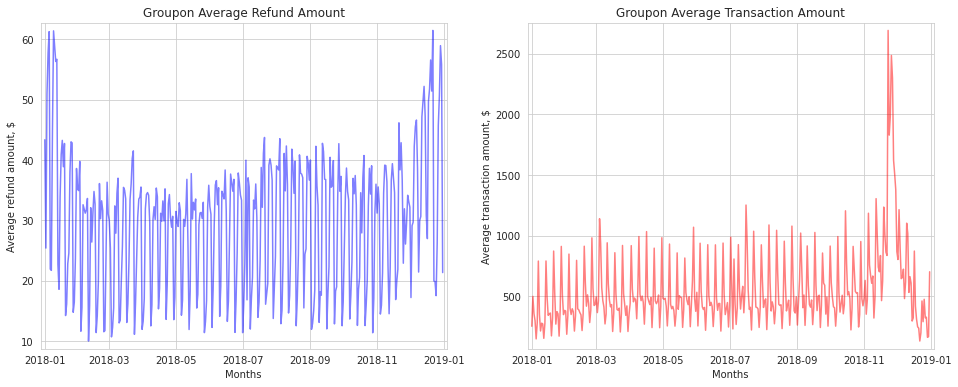

In [99]:
%matplotlib inline
sns.set_style('whitegrid')
plt.figure()
plt.figure(figsize=(16,6))
# subplot 1
plt.subplot(1,2,1)
plt.plot(avg_data['refunds'], 'b-', alpha=0.5)
# add legend, title, and labels
# plt.text('2018-1-1',30,'New Year Day')
# plt.xticks( np.linspace(15,15 + 30*11 , num = 12), (r'Jan', r'Feb', r'Mar', r'Apr', r'May', r'Jun', r'Jul', r'Aug', r'Sep', r'Oct', r'Nov', r'Dec') )
plt.xlabel('Months')
plt.ylabel('Average refund amount, $')
plt.title(r'Groupon Average Refund Amount')
plt.margins(0.010, 0.025)
# subplot 2
plt.subplot(1,2,2)
plt.plot(avg_data['capture_bookings'], 'r-', alpha=0.5)

# add legend, title, and labels
# plt.xticks( np.linspace(15,15 + 30*11 , num = 12), (r'Jan', r'Feb', r'Mar', r'Apr', r'May', r'Jun', r'Jul', r'Aug', r'Sep', r'Oct', r'Nov', r'Dec') )
plt.xlabel('Months')
plt.ylabel('Average transaction amount, $')
plt.title(r'Groupon Average Transaction Amount')
plt.margins(0.010, 0.025)
plt.show()

From the following plots, we can clearly see that refunds and transactions have spikes and valleys. We can observe the biggest transaction spike during Thanksgiving and Christmas season when most people shop for gifts. We can also observe the highest amount of refunds at the end of December and January, when people return gifts they didn't like.

In [66]:
avg_data = subset.groupby(['month','day']).agg({'refunds':np.mean,'capture_bookings':np.mean})
# avg_by_day = avg_data.pivot_table('refunds',
#                                  [avg_data.index.month,avg_data.index.day])
avg_data.index = [datetime(2018,month,day) for (month, day) in avg_data.index]

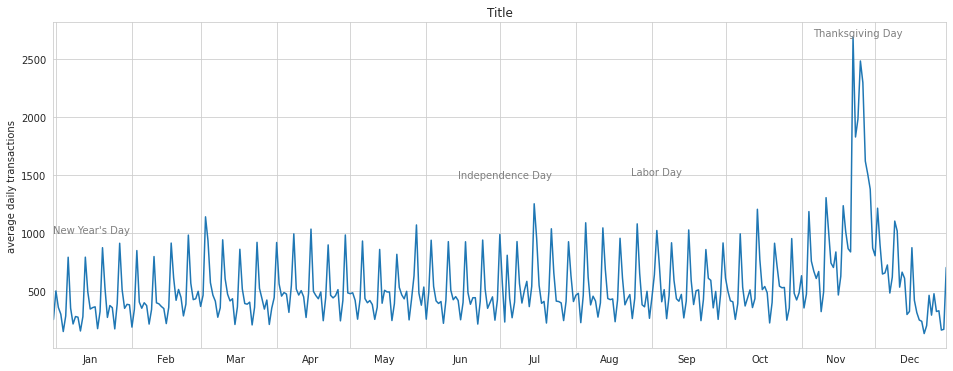

In [98]:
fig, ax = plt.subplots(figsize=(16,6))
avg_data['capture_bookings'].plot(ax=ax)

# add lables to the plot
style = dict(size=10, color='gray')
ax.text('2018-01-01',1000, "New Year's Day",**style)
ax.text('2018-7-4',1500, 'Independence Day',ha='center',va='center',**style)
ax.text('2018-9-4',1500,'Labor Day',ha='center',**style)
ax.text('2018-11-25',2700,'Thanksgiving Day',ha='center',**style)

ax.set(title='Title', ylabel='average daily transactions')

# formatters' options
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%b'))
plt.show()

### Part 2. Machine Learning Modeling.